In [14]:
import numpy as np

In [15]:
mnist2d_points = np.load("mnist2d-points.npy")
mnist2d_labels = np.load("mnist2d-labels.npy")

In [16]:
mnist2d_points.shape, mnist2d_labels.shape

((70000, 400, 2), (70000, 1))

In [17]:
X_train, X_test = mnist2d_points[:60000], mnist2d_points[60000:]
y_train, y_test = mnist2d_labels[:60000], mnist2d_labels[60000:]

In [18]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 400, 2), (10000, 400, 2), (60000, 1), (10000, 1))

In [36]:
def get_examples(n_examples):
    """
    - takes number of examples as input
    - returns random subset of examples from X_train, rotated examples, angles of rotation and original labels 
    """
    global X_train, y_train
    
    ix = np.random.choice(range(len(X_train)), size=n_examples)
    
    examples = X_train[ix]
    theta = np.pi / 2 * np.random.rand(n_examples) # theta in [0, pi / 2]
    
    
    rotated_examples = []
    for i in range(n_examples):
        rotation_matrix = np.array([[np.cos(-theta[i]), np.sin(-theta[i])],
                                    [-np.sin(-theta[i]), np.cos(-theta[i])]])
        
        rotated_examples.append(np.dot(examples[i], rotation_matrix))
    
    rotated_examples = np.array(rotated_examples)
    delta = np.array([0.5, 0.5]) - rotated_examples.mean(axis=1).reshape(10, 1, 2)
    print(rotated_examples.shape)
    print(delta.shape)
    rotated_examples += delta
    return examples, rotated_examples, theta, y_train[ix]

In [37]:
examples, rotated_examples, theta, labels = get_examples(10)

(10, 400, 2)
(10, 1, 2)


In [38]:
import matplotlib.pyplot as plt

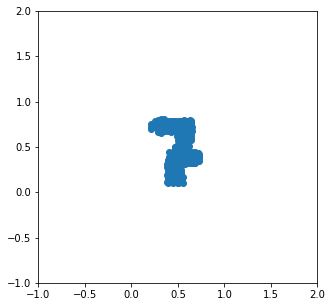

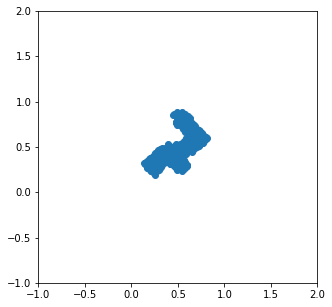

[7]


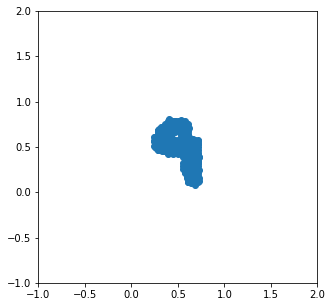

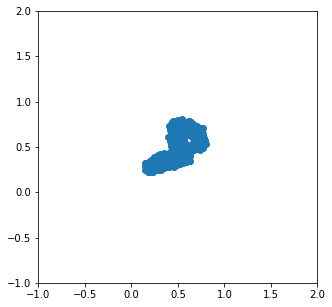

[9]


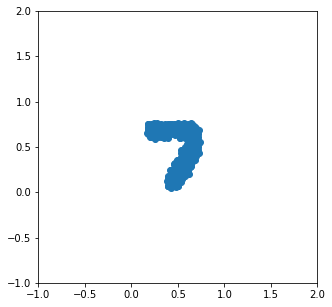

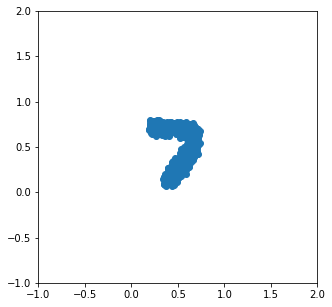

[7]


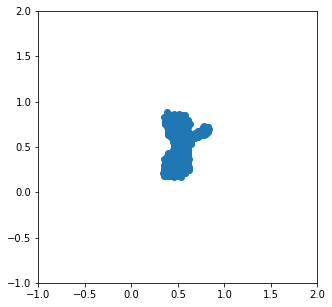

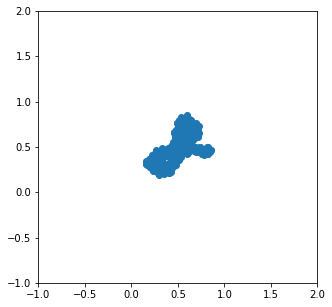

[8]


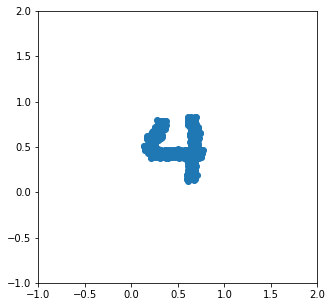

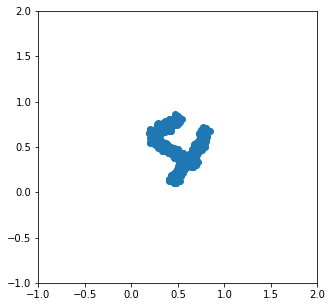

[4]


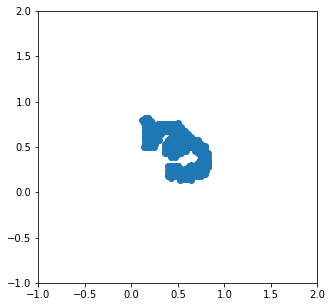

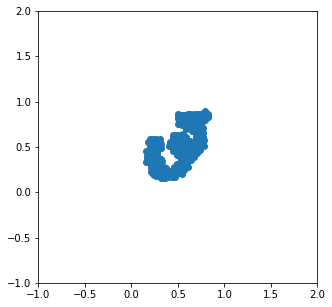

[3]


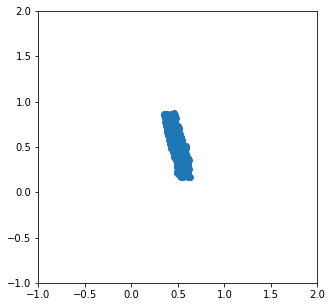

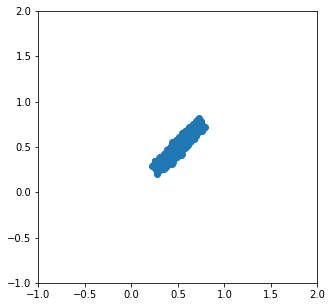

[1]


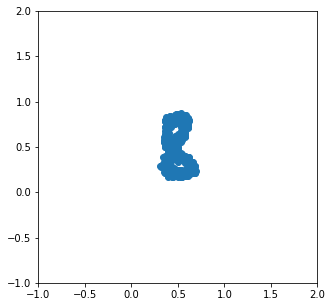

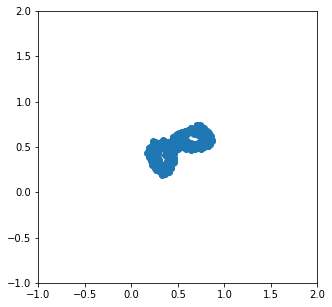

[8]


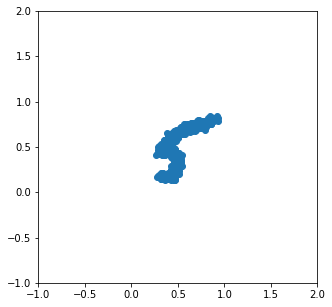

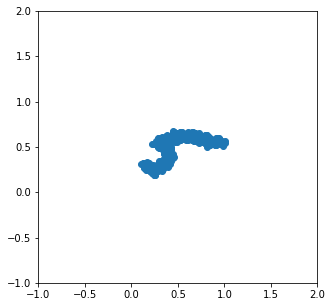

[5]


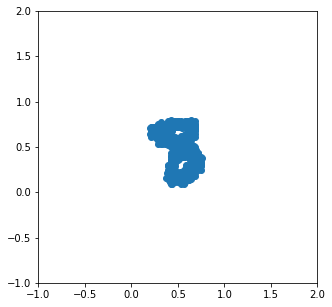

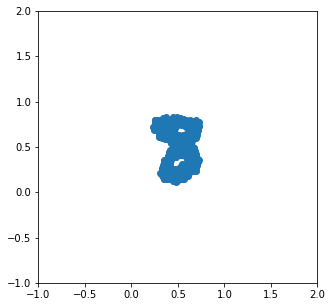

[8]


In [39]:
for i in range(len(examples)):
    plt.figure(figsize=(5, 5))
    plt.scatter(examples[i][:, 0], examples[i][:, 1])
    plt.xlim(-1, 2)
    plt.ylim(-1, 2)
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.scatter(rotated_examples[i][:, 0], rotated_examples[i][:, 1])
    plt.xlim(-1, 2)
    plt.ylim(-1, 2)
    plt.show()
    
    print(labels[i])